In [43]:
import numpy as np
from numpy.typing import ArrayLike
import warnings

In [44]:
warnings.filterwarnings('ignore')
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [45]:
def int_to_one_hot(y: ArrayLike, num_labels: int):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

In [46]:
class NeuralNetMPL:
    def __init__(
        self,
        num_features: int,
        num_hidden: int,
        num_classes: int,
        random_seed: int = 123
    ):
        """
            Initialize the weight matrices and bias vectors for the hidden and output layer 
        """
        self.num_classes = num_classes
        
        # hidden layer
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(
            loc=0.0,
            scale=0.1,
            size=(num_hidden, num_features)
        )
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0,
            scale=0.1,
            size=(num_classes, num_hidden)
        )
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        """
            Take in one or more training examples and return the predictions
            (activation values from the hidden and output layers)
        """

        # Hidden layer
        # Input dim: [n_hidden, n_features]
        # Weight dim: [n_features, n_examples].T
        # Output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # Input Dim: [n_classes, n_hidden]
        # Weight Dim: [n_hidden, n_examples]
        # Output Dim: [n_examples, n_classes] 
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        """
            This method updates the weight and bias parameters of the neural network
            with backpropagation method
        """

        # one-hot encoding
        y_one_hot = int_to_one_hot(y, self.num_classes)

        ''' Part 1: dLoss / dOutWeights '''
        # dLoss / dOutWeights = dLoss / dOutAct * dOutAct / dOutNet * dOutNet / dOutWeight
        # where DeltaOut = dOutAct / dOutNet * dOutNet / dOutWeight

        # input / output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.0 * (a_out - y_one_hot) / y.shape[0]

        # input / output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1.0 - a_out) # sigmoid derivative

        # output_dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # gradient for output weights [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # Input Dim: [n_classes, n_examples]
        # Weight Dim: [n_examples, n_hidden]
        # Output Dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        ''' Part 2: dLoss / dHiddenWeights '''
        # dLoss / dHiddenWeights = DeltaOut * dOutNet / dHiddenAct * dHiddenAct / dHiddenNet * dHiddenNet / dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1.0 - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [47]:
model = NeuralNetMPL(
    num_features=28*28, # image dimension in pixels
    num_hidden=50,  # number of nodes in hidden layer
    num_classes=10  # number of digits 0 - 9
)

In [48]:
# training loop
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx: start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

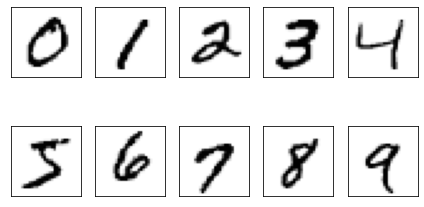

In [49]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

X_norm = ((X / 255.0) - 0.5) * 2 # normalize between -1 and 1

# Plot data
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_norm[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

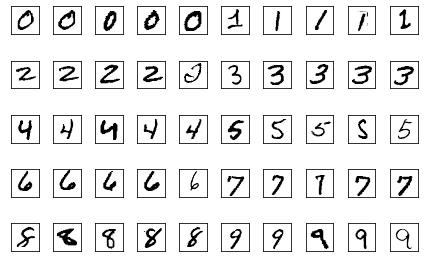

In [50]:
# plot examples of the same digit
nclasses = 10
nrows = 5
ncols = 10
total_digits = nrows * ncols

fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True
)
ax = ax.flatten()
j = 0
for i in range(total_digits):
    if i % 5 == 0 and i > 4:
        j += 1
    img = X[y == j][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [51]:
# divide dataset into training, testing and validation subsets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X_norm, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [52]:
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [53]:
# define loss function
def mse_loss(targets, probas, num_labels=10):
    one_hot_targets = int_to_one_hot(targets, num_labels=num_labels)
    return np.mean((one_hot_targets - probas) ** 2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [54]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:1f}')

Initial validation MSE: 0.270756


In [55]:
def compute_mse_and_acc(nnet: NeuralNetMPL, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        one_hot_targets = int_to_one_hot(targets, num_labels=num_labels)
        loss = np.mean((one_hot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / i
    acc = correct_pred / num_examples
    return mse, acc

In [56]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f"Initial valid MSE: {mse:.1f}")
print(f"Initial valid accuracy: {acc:.1f}")

Initial valid MSE: 0.3
Initial valid accuracy: 0.1


In [57]:
def train(model: NeuralNetMPL, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    for epoch in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size=100)
        for X_train_mini, y_train_mini in minibatch_gen:
            # compute outputs
            a_h, a_out = model.forward(X_train_mini)
            # compute gradients
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)
            # update weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        # epoch logging
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [59]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model=model, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid,
    num_epochs=200, learning_rate=0.1
)

Epoch: 001/200 | Train MSE: 0.01 | Train Acc: 95.69% | Valid Acc: 94.66%
Epoch: 002/200 | Train MSE: 0.01 | Train Acc: 95.65% | Valid Acc: 94.60%
Epoch: 003/200 | Train MSE: 0.01 | Train Acc: 95.77% | Valid Acc: 94.70%
Epoch: 004/200 | Train MSE: 0.01 | Train Acc: 95.81% | Valid Acc: 94.84%
Epoch: 005/200 | Train MSE: 0.01 | Train Acc: 95.83% | Valid Acc: 94.88%
Epoch: 006/200 | Train MSE: 0.01 | Train Acc: 95.81% | Valid Acc: 94.84%
Epoch: 007/200 | Train MSE: 0.01 | Train Acc: 95.91% | Valid Acc: 94.86%
Epoch: 008/200 | Train MSE: 0.01 | Train Acc: 95.97% | Valid Acc: 94.92%
Epoch: 009/200 | Train MSE: 0.01 | Train Acc: 96.00% | Valid Acc: 95.02%
Epoch: 010/200 | Train MSE: 0.01 | Train Acc: 96.01% | Valid Acc: 94.94%
Epoch: 011/200 | Train MSE: 0.01 | Train Acc: 96.06% | Valid Acc: 94.94%
Epoch: 012/200 | Train MSE: 0.01 | Train Acc: 96.09% | Valid Acc: 95.16%
Epoch: 013/200 | Train MSE: 0.01 | Train Acc: 96.10% | Valid Acc: 95.08%
Epoch: 014/200 | Train MSE: 0.01 | Train Acc: 96.13

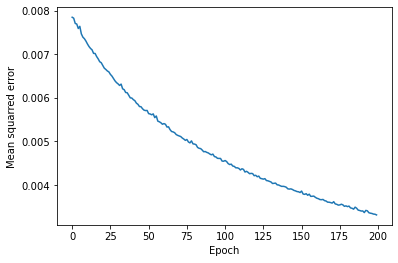

In [60]:
# evaluate NN performance
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squarred error')
plt.xlabel('Epoch')
plt.show()

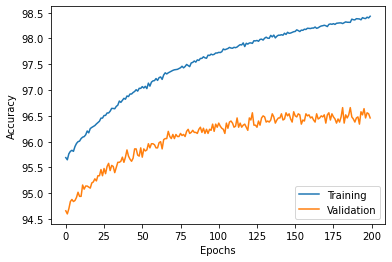

In [61]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [62]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test_accuracy: {test_acc*100:.2f}%')

Test_accuracy: 96.25%


In [63]:
# save the model
import pickle
with open('MPL_model.pickle', mode='wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# plot missclassified images
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_mask = y_test_subset != test_pred
misclassified_images = X_test_subset[misclassified_mask][:25]
misclassified_labels = test_pred[misclassified_mask][:25]
correct_labels = y_test_subset[misclassified_mask][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1} '
                    f'True: {correct_labels[i]}\n'
                    f'Predicted: {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.show()